Préliminaire: préparation des données sous forme d'arbres

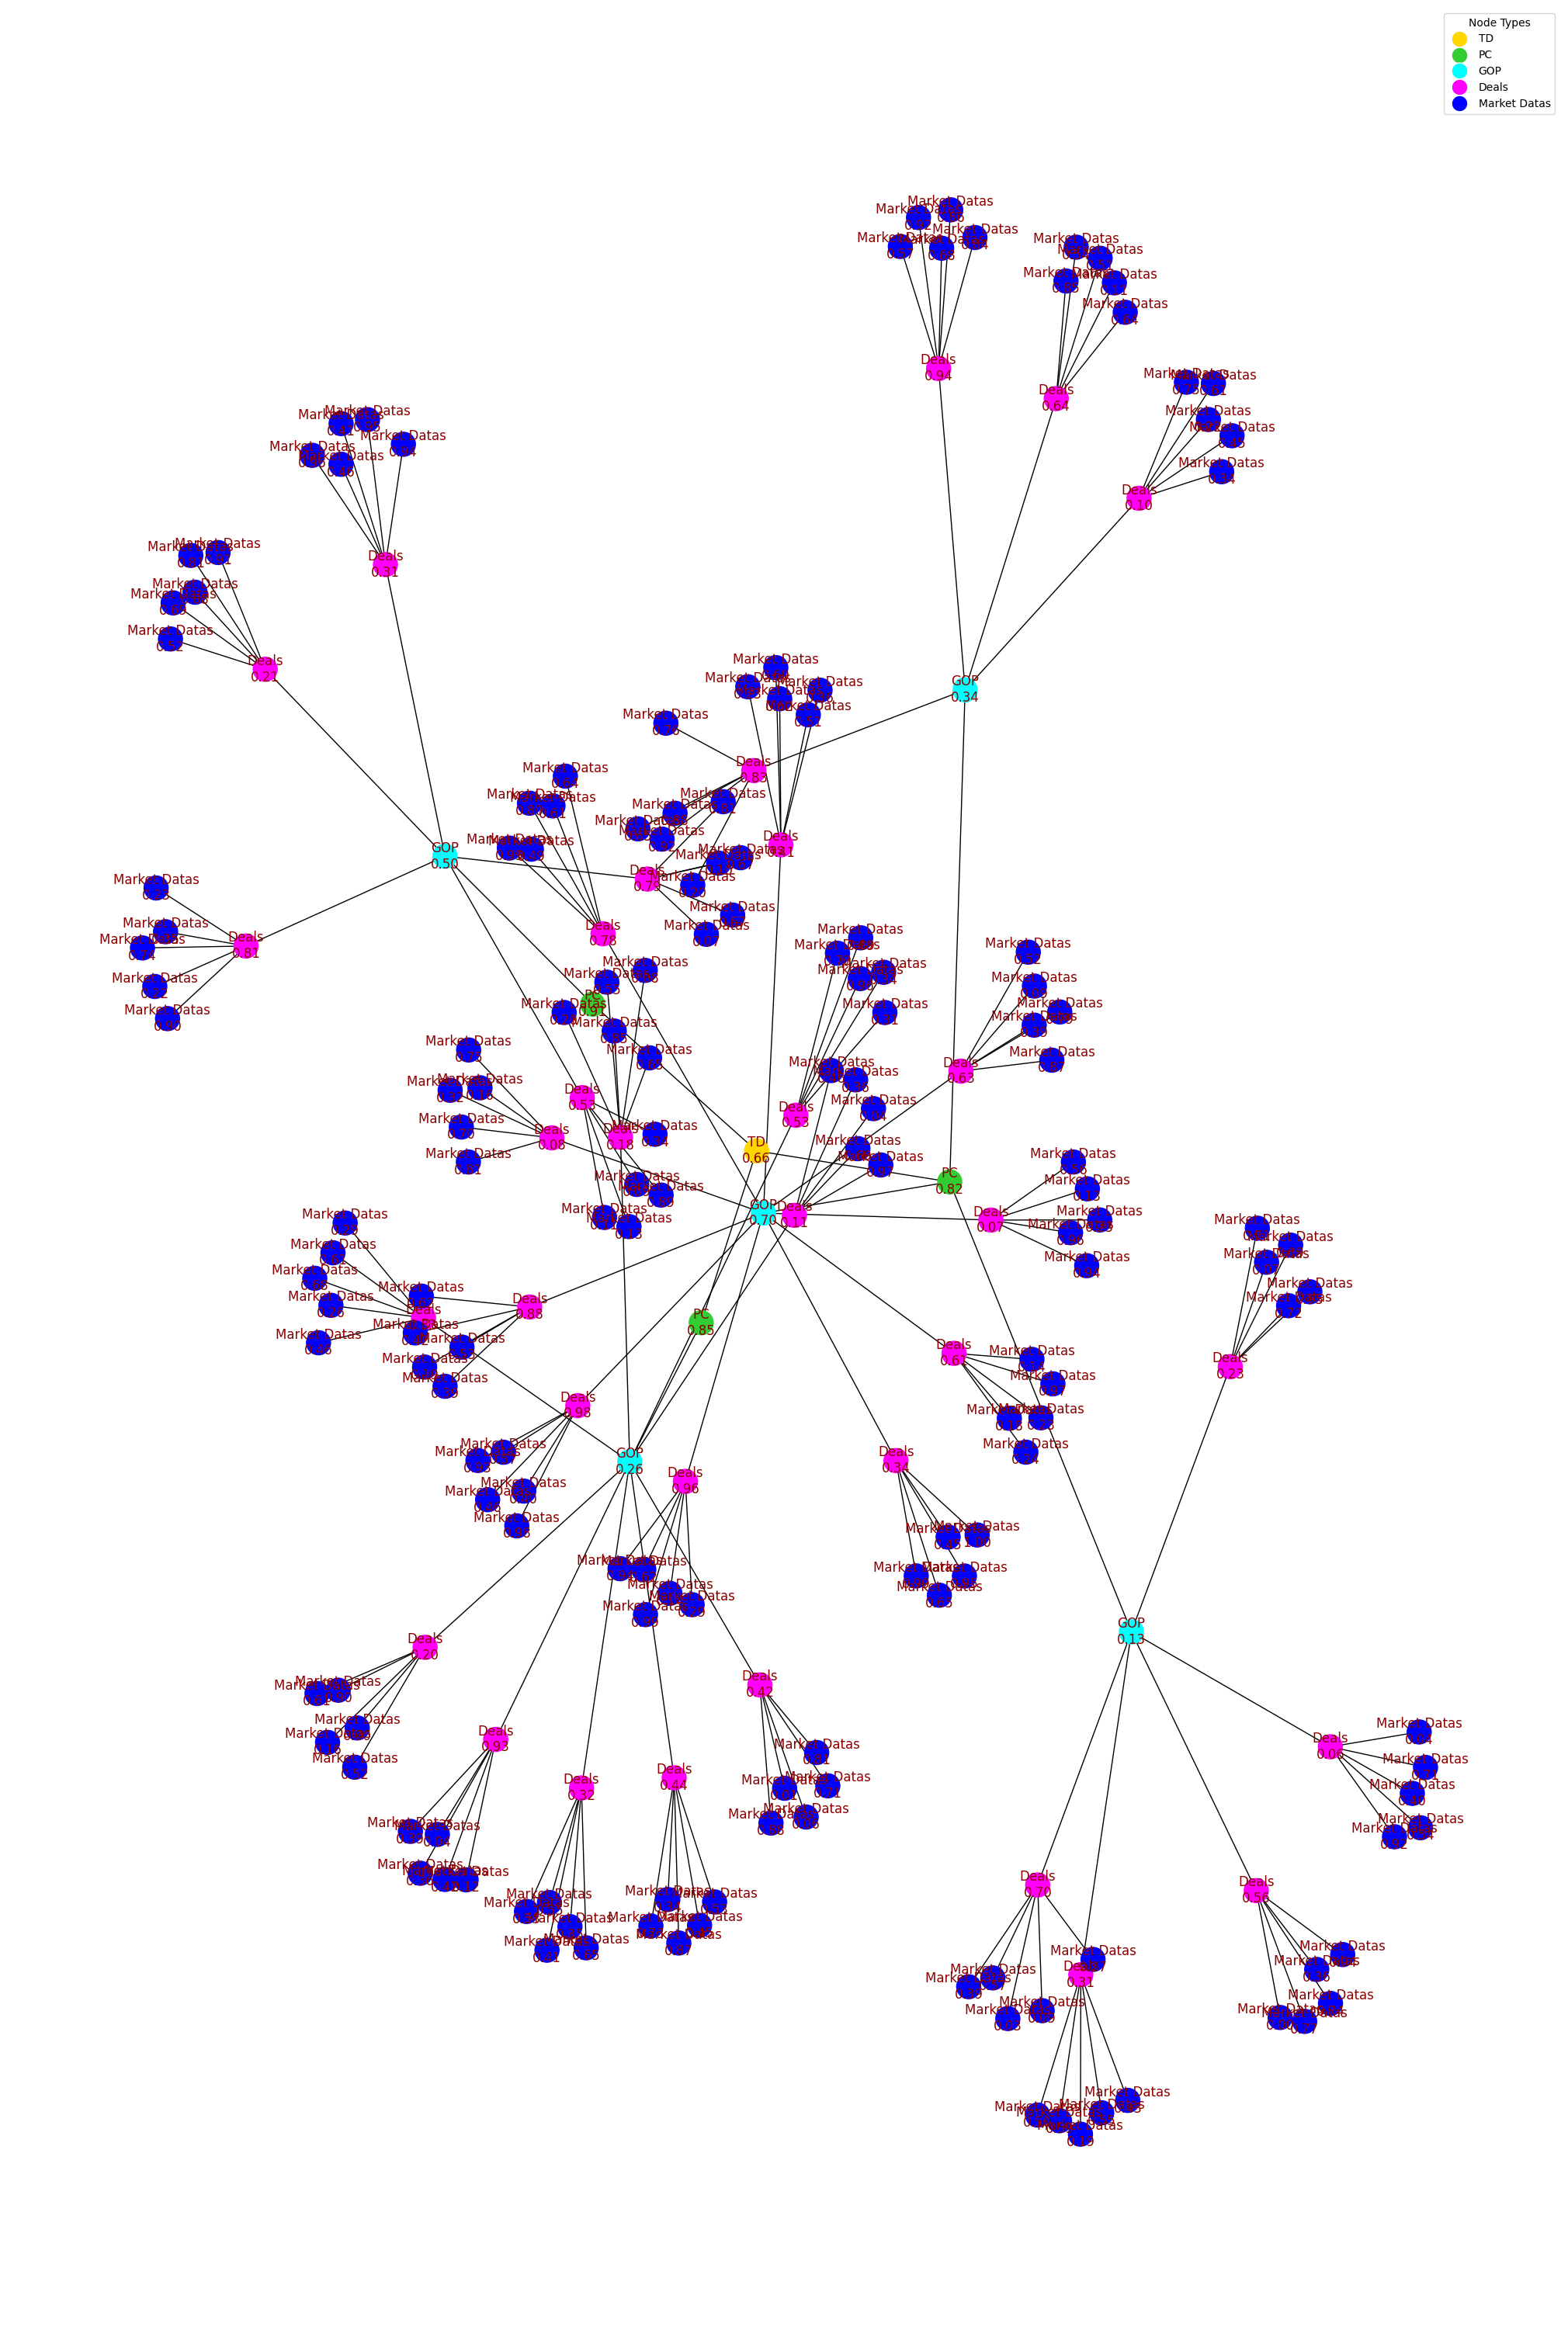

In [27]:
import dgl
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt

def generate_tree():
    # Initialisation du graphe
    g = dgl.graph(([], []))
    labels = ['TD']  # Étiquette pour le nœud racine
    g.add_nodes(1)
    node_features = [np.random.rand()]  # Indice aléatoire pour la racine

    # Niveau 1: enfants 'PC' de 'TD'
    num_children_td = np.random.randint(2, 6)  # entre 2 et 5 enfants
    pc_nodes = list(range(g.num_nodes(), g.num_nodes() + num_children_td))
    g.add_nodes(num_children_td)
    node_features.extend(np.random.rand(num_children_td).tolist())
    labels.extend(['PC'] * num_children_td)
    g.add_edges([0] * num_children_td, pc_nodes)

    # Niveau 2: enfants 'GOP' de chaque 'PC'
    gop_nodes = []
    for pc_node in pc_nodes:
        num_children_pc = np.random.randint(1, 4)  # entre 1 et 3 enfants
        children = list(range(g.num_nodes(), g.num_nodes() + num_children_pc))
        g.add_nodes(num_children_pc)
        node_features.extend(np.random.rand(num_children_pc).tolist())
        labels.extend(['GOP'] * num_children_pc)
        g.add_edges([pc_node] * num_children_pc, children)
        gop_nodes.extend(children)

    # Niveau 3: enfants 'Deals' de chaque 'GOP'
    deal_nodes = []
    for gop_node in gop_nodes:
        num_children_gop = np.random.randint(4, 11)  # entre 4 et 10 enfants
        children = list(range(g.num_nodes(), g.num_nodes() + num_children_gop))
        g.add_nodes(num_children_gop)
        node_features.extend(np.random.rand(num_children_gop).tolist())
        labels.extend(['Deals'] * num_children_gop)
        g.add_edges([gop_node] * num_children_gop, children)
        deal_nodes.extend(children)

    # Niveau 4: enfants 'Market Datas' de chaque 'Deal', chacun ayant exactement 5 enfants
    for deal_node in deal_nodes:
        num_children_deal = 5
        children = list(range(g.num_nodes(), g.num_nodes() + num_children_deal))
        g.add_nodes(num_children_deal)
        node_features.extend(np.random.rand(num_children_deal).tolist())
        labels.extend(['Market Datas'] * num_children_deal)
        g.add_edges([deal_node] * num_children_deal, children)

    # Assignation des indices aléatoires comme caractéristiques des nœuds
    g.ndata['feature'] = torch.tensor(node_features, dtype=torch.float32)
    return g, labels

def plot_tree(g, labels):
    plt.figure(figsize=(20, 30))
    nx_g = g.to_networkx().to_undirected()
    pos = nx.spring_layout(nx_g, scale=20)

    color_map = {
        'TD': 'gold',
        'PC': 'limegreen',
        'GOP': 'cyan',
        'Deals': 'magenta',
        'Market Datas': 'blue'
    }
    node_color = [color_map[label] for label in labels]
    node_labels = {i: f"{label}\n{g.ndata['feature'][i].item():.2f}" for i, label in enumerate(labels)}

    nx.draw(nx_g, pos, node_color=node_color, with_labels=True, labels=node_labels, node_size=500, font_size=12, font_color='darkred')

    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                              markerfacecolor=val, markersize=15) for key, val in color_map.items()]
    plt.legend(handles=legend_elements, title="Node Types")
    plt.show()

# Génération du graphe et labels
tree, labels = generate_tree()

# Visualisation du graphe
plot_tree(tree, labels)


In [31]:
import numpy as np
import dgl

def generate_data(num_samples=100, zero_ratio=0.3):
    X = []
    y = []
    
    # Détermination du nombre de labels à 0 et 1
    num_zeros = int(num_samples * zero_ratio)
    num_ones = num_samples - num_zeros
    labels = [0] * num_zeros + [1] * num_ones
    np.random.shuffle(labels)  # Mélange des labels pour randomisation
    
    for label in labels:
        # Génération du graphe
        g, node_labels = generate_tree()
        X.append((g,node_labels))
        y.append(label)
    
    return X, y

# Appel de la fonction pour générer les données
X, y = generate_data()

# Vérification rapide des proportions et de la taille de la liste
print("Total samples:", len(X))
print("Number of 0s:", y.count(0))
print("Number of 1s:", y.count(1))


Total samples: 100
Number of 0s: 30
Number of 1s: 70


1. Définir le Modèle de Réseau de Neurones pour Graphes


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, features):
        x = F.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        x = dgl.mean_nodes(g, 'h')  # Moyenne des embeddings des nœuds pour obtenir une représentation globale du graphe
        return x


2. Préparation des Données


In [34]:
from torch.utils.data import DataLoader

def collate(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch([g for g, _ in graphs])
    features = torch.cat([g.ndata['feature'].float().unsqueeze(1) for g, _ in graphs], 0)
    labels = torch.tensor(labels)
    return batched_graph, features, labels

# Transformer les données en paires (graphe, label)
graph_label_pairs = [(X[i][0], y[i]) for i in range(len(y))]
data_loader = DataLoader(graph_label_pairs, batch_size=10, shuffle=True, collate_fn=collate)


3. Entraînement du Modèle


In [35]:
# Configuration de l'apprentissage
model = GCN(in_feats=1, h_feats=16, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train():
    for epoch in range(10):  # On fait un entraînement simple pour tester
        for batched_graph, features, labels in data_loader:
            pred = model(batched_graph, features)
            loss = criterion(pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

train()


DGLError: Invalid key "0". Must be one of the edge types.